In [1]:
%cd ../

/home/tk/repos/erc


In [2]:
from utils import read_json, read_yaml, gets_DATASET_kwargs
from utils import get_tokenizer_model_ds, get_diaid_uttid_utts, return_coeffs

model_checkpoint = 'results/MELD/roberta-large/2021-05-23-00-20-58/4/checkpoint-12490/'
# model_checkpoint = 'results/IEMOCAP/roberta-large/2021-05-21-07-58-04/3/checkpoint-4780/'

DATASET, kwargs = gets_DATASET_kwargs(model_checkpoint)
DATASET, kwargs

/home/tk/repos/erc/utils/helper.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  foo = yaml.load(stream)


('MELD',
 {'ADD_BOU_EOU': False,
  'ADD_SPEAKER_TOKENS': True,
  'BATCH_SIZE': 4,
  'DATASET': 'MELD',
  'HP_N_TRIALS': 5,
  'HP_ONLY_UPTO': 103,
  'NUM_TRAIN_EPOCHS': 5,
  'REPLACE_NAMES_IN_UTTERANCES': False,
  'SEEDS': [0, 1, 2, 3, 4],
  'SPEAKER_SPLITS': ['train', 'val', 'test'],
  'WARMUP_RATIO': 0.2,
  'WEIGHT_DECAY': 0.01,
  'model_checkpoint': 'roberta-large',
  'num_future_utterances': 0,
  'num_past_utterances': 1000,
  'training_config': 'train-erc-text2.yaml'})

In [3]:
tokenizer, model, ds = get_tokenizer_model_ds(DATASET, kwargs, model_checkpoint, SPLIT='train')

2021-05-27 16:49:54.879 INFO utils - _load_utterance_ordered: every text file exists fine!
2021-05-27 16:49:54.879 INFO utils - _string2tokens: converting utterances into tokens ...
2021-05-27 16:49:54.881 INFO utils - _string2tokens: creating input utterance data ... 
100%|██████████| 1038/1038 [00:15<00:00, 66.13it/s]
2021-05-27 16:50:11.256 INFO utils - _create_input: number of truncated utterances: 2


In [4]:
import pprint
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


idx, input_ids, attention_mask, labelid, decoded, diaid, uttid, utt, utts = get_diaid_uttid_utts(ds, tokenizer)

pprint.pprint(f"{decoded}")
print()

outputs = model(**{'input_ids': input_ids, 'attention_mask': attention_mask}, labels=labelid, output_attentions=True, output_hidden_states=True)
attentions = outputs.attentions
pred = int(outputs.logits.argmax().numpy())
truth = int(labelid[0][0].numpy())

pprint.pprint(f"data_idx: {idx}")
pprint.pprint(f"pred: {ds.id2emotion[pred]}")
pprint.pprint(f"truth: {ds.id2emotion[truth]}")
pprint.pprint(f"number of tokens in the input: {input_ids.shape[1]}")
print()

idx: 1146

diaid: dia418 
uttid: dia418_utt3

[0, 50393, 30086, 328, 38, 17, 27, 119, 925, 4, 10057, 8022, 368, 857, 8, 38, 33, 10, 367, 6108, 1142, 38, 240, 7, 1394, 47, 4, 50421, 30327, 116, 38, 17, 27, 548, 57, 4098, 19, 925, 4, 6093, 4, 50393, 100, 216, 6, 53, 38, 17, 27, 119, 10, 31649, 661, 4, 2, 2, 50393, 2409, 95, 7, 28, 15, 5, 1522, 526, 6, 925, 4, 6093, 770, 10, 55, 5145, 13433, 9, 47, 2194, 98, 37, 1051, 162, 4, 2]

<s><Joey>Hi! I’m Dr. Drake Remoray and I have a few routine questions I need to ask you.<Man>Really? I’ve been dealing with Dr. Wells.<Joey>I know, but I’m a neurologist.</s></s><Joey>And just to be on the safe side, Dr. Wells wanted a more comprehensive overview of you status so he sent me.</s>

(neutral) <Joey>And just to be on the safe side, Dr. Wells wanted a more comprehensive overview of you status so he sent me.

('dia418_utt0, (neutral) <Joey>Hi! I’m Dr. Drake Remoray and I have a few '
 'routine questions I need to ask you.')
'dia418_utt1, (surprise) <Ma

In [5]:
decoded

'<s><Joey>Hi! I’m Dr. Drake Remoray and I have a few routine questions I need to ask you.<Man>Really? I’ve been dealing with Dr. Wells.<Joey>I know, but I’m a neurologist.</s></s><Joey>And just to be on the safe side, Dr. Wells wanted a more comprehensive overview of you status so he sent me.</s>'

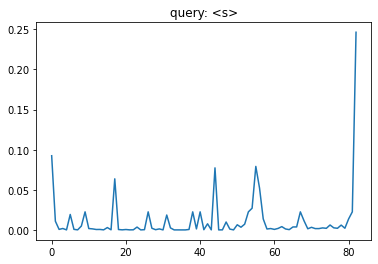

[(0, '<s>', 0.09249679), (1, '<Joey>', 0.010879917), (2, 'Hi', 0.0006830105), (3, '!', 0.0018044492), (4, 'I', 8.730368e-05), (5, 'âĢ', 0.019295882), (6, 'Ļ', 0.0007383877), (7, 'm', 0.00011407709), (8, 'Dr', 0.0048575667), (9, '.', 0.02254547), (10, 'Drake', 0.0017464121), (11, 'Rem', 0.0013301295), (12, 'or', 0.0005684545), (13, 'ay', 0.00062028365), (14, 'and', 0.00011733377), (15, 'I', 0.0029691441), (16, 'have', 0.00016837135), (17, 'a', 0.0636958), (18, 'few', 0.00052024215), (19, 'routine', 0.0001337978), (20, 'questions', 0.00052747404), (21, 'I', 9.832939e-05), (22, 'need', 0.00016893185), (23, 'to', 0.003568904), (24, 'ask', 5.7894962e-05), (25, 'you', 0.00033108698), (26, '.', 0.022545487), (27, '<Man>', 0.0021035154), (28, 'Really', 0.0003043648), (29, '?', 0.001288914), (30, 'I', 5.0445306e-05), (31, 'âĢ', 0.018586779), (32, 'Ļ', 0.002555638), (33, 've', 4.8903017e-05), (34, 'been', 4.808689e-05), (35, 'dealing', 2.9884099e-05), (36, 'with', 4.0920626e-05), (37, 'Dr', 0.00

In [6]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=-1, QUERY_TOKEN_IDX=0)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)

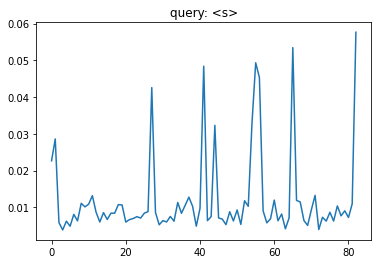

[(0, '<s>', 0.022653831), (1, '<Joey>', 0.028610503), (2, 'Hi', 0.005821994), (3, '!', 0.0038452626), (4, 'I', 0.0062264167), (5, 'âĢ', 0.0048522092), (6, 'Ļ', 0.008075174), (7, 'm', 0.00630231), (8, 'Dr', 0.011089333), (9, '.', 0.010117874), (10, 'Drake', 0.010847836), (11, 'Rem', 0.01316568), (12, 'or', 0.008661462), (13, 'ay', 0.005998225), (14, 'and', 0.008558411), (15, 'I', 0.0066854605), (16, 'have', 0.008398946), (17, 'a', 0.008397085), (18, 'few', 0.010731436), (19, 'routine', 0.010633842), (20, 'questions', 0.005987451), (21, 'I', 0.006650354), (22, 'need', 0.006952608), (23, 'to', 0.007451642), (24, 'ask', 0.0070685106), (25, 'you', 0.008404595), (26, '.', 0.0088399), (27, '<Man>', 0.042582978), (28, 'Really', 0.00861693), (29, '?', 0.005236387), (30, 'I', 0.0063756756), (31, 'âĢ', 0.0060144067), (32, 'Ļ', 0.0075108022), (33, 've', 0.0062186606), (34, 'been', 0.011318507), (35, 'dealing', 0.008370879), (36, 'with', 0.0105367135), (37, 'Dr', 0.012768372), (38, '.', 0.010270173

In [7]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=0, QUERY_TOKEN_IDX=0)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)